Decimation      : 256
Frequency       : 488.281 kHz
Duration        : 33.554 msec
Trigger         : CH2_PE
Trigger Delay   : 0 samples
Trigger Level   : 0.000 Volt
Range 1         : +/-1.0 Volt
Range 2         : +/-1.0 Volt
Probe 1         : 1x
Probe 2         : 1x
TD
Trigger delay   : 0.016777 Sec
Decimation      : 256
Frequency       : 488.281 kHz
Duration        : 33.554 msec
Trigger         : CH2_PE
Trigger Delay   : 0 samples
Trigger Level   : 0.000 Volt
Range 1         : +/-1.0 Volt
Range 2         : +/-1.0 Volt
Probe 1         : 1x
Probe 2         : 1x
TD
Trigger delay   : 0.016777 Sec
Decimation      : 256
Frequency       : 488.281 kHz
Duration        : 33.554 msec
Trigger         : CH2_PE
Trigger Delay   : 0 samples
Trigger Level   : 0.000 Volt
Range 1         : +/-1.0 Volt
Range 2         : +/-1.0 Volt
Probe 1         : 1x
Probe 2         : 1x
TD
Trigger delay   : 0.016777 Sec
Decimation      : 256
Frequency       : 488.281 kHz
Duration        : 33.554 msec
Trigger         : 

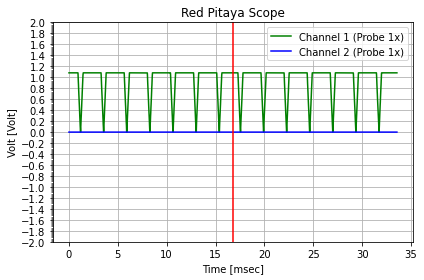

In [1]:
#==============================================================================
# Simple scope script using scpi interface to te RP.
# Not very fast, but enough to check if there is data and 
# check for example the signal generator is running.
#
# M. Hajer, 2021
#==============================================================================

import sys
sys.path.append('../classes')

import os
import time
import redpitaya_scpi as scpi
import matplotlib.pyplot as plt
import numpy as np
from redpitaya_class import redpitaya_scope as redpitaya_scope
import addcopyfighandler
import mplcursors

#==============================================================================
# Prepare a plot and store the line handles for easy update later.
#==============================================================================
def PreparePlot(Scope):
    fig = plt.figure()
    ax1 = plt.subplot(111)
    ax1.grid(True)
    ax1.set(ylabel='Volt [Volt]', xlabel='Time [msec]', title='Title')
    ax1.set_ylim([-20.0, 20.0])

    x = Scope.GetTimeVector() * 1000

    # Extra vertical line to indicate the trigger moment
    x_trig = Scope.GetTriggerVector() * 1000
    y_trig = Scope.GetTriggerData()
   
    y1 = np.zeros((16384, 1))
    y2 = np.zeros((16384, 1))

    label_ch1 = ("Channel 1 (Probe %0.fx)" % + Scope.GetProbeGain(1))
    label_ch2 = ("Channel 2 (Probe %0.fx)" % + Scope.GetProbeGain(2))
    label_trig = ("Trigger position")

    line1,       = ax1.plot(x, y1, 'g-', label=label_ch1) # Returns a tuple of line objects, thus the comma
    line2,       = ax1.plot(x, y2, 'b-', label=label_ch2) # Returns a tuple of line objects, thus the comma
    triggerline, = ax1.plot(x_trig, y_trig, 'r-') 

    # Set plot axes based on probe scaling
    if (Scope.GetProbeGain(Probe = 1) == 10):
        SetPlotYAxis(ax1, 20)
    elif (Scope.GetProbeGain(Probe = 2) == 10):
        SetPlotYAxis(ax1, 20)
    else:
        SetPlotYAxis(ax1, 2)

    leg = ax1.legend();
   
    plt.tight_layout()
    plt.title('Red Pitaya Scope')
    
    return fig, plt, line1, line2, triggerline, ax1


#==============================================================================
# Update the X & Y axes based on the actual scope setttings
# Generate minor ticks
#==============================================================================
def SetPlotYAxis(axis, YRange):
    Major = YRange / 10;
    Minor = YRange / 100;
    
    y_major_ticks = np.arange(-1 * YRange, YRange + Minor, Major)
    y_minor_ticks = np.arange(-1 * YRange, YRange + Minor, Minor)

    axis.set_yticks(y_major_ticks)
    axis.set_yticks(y_minor_ticks, minor=True)
    
    axis.set_ylim([-1 * YRange, YRange])

    return
    

#==============================================================================
# Axctual plotting function. 
# Called when data is available
#==============================================================================
def UpdatePlot(Scope, fig, line1, line2, triggerline, Data1, Data2):
    line1.set_ydata(Data1)
    line2.set_ydata(Data2)
    
    
    x_trig = Scope.GetTriggerVector() * 1000
    y_trig = np.array([-1.0 , 1.0]) * 20.0

    triggerline.set_xdata(x_trig)
    triggerline.set_ydata(y_trig)

    fig.canvas.draw()
    fig.canvas.flush_events()
            
    return


#==============================================================================
# Main
#==============================================================================
def main():
    ip = "192.168.3.150"
    
    # create a scpi object.
    Pitaya = scpi.scpi(ip)
   
    # Create a scope object and set some parameters
    Scope = redpitaya_scope(Pitaya);     
    Scope.SetDecimationBeta(8)    
    Scope.SetInputGain(Channel = 1, Gain = 'LV')
    Scope.SetInputGain(Channel = 2, Gain = 'LV')
    Scope.SetProbeGain(Probe = 1, Gain = 1)
    Scope.SetProbeGain(Probe = 2, Gain = 1)
    Scope.SetAverage(0)
    Scope.SetTrigger(Trigger = "NOW")

    [fig, plt, line1, line2, triggerline, ax1] = PreparePlot(Scope)
       
    try:
        while True:
            Scope.SetTrigger(Trigger = "DISABLED")
            Scope.Start()   
    
            # Sleep is only needed when trigger delay = 0 (middle of the data) 
            # In that case we want to make sure the pre-trigger buffer is full
            # before setting the actual trigger.
            # time.sleep(1)
    
            Scope.SetTrigger(Trigger = "CH2_PE", Level = 0.0, Delay = 0)
            # Scope.SetTrigger(Trigger = "NOW")
            Scope.PrintSettings()

            Scope.WaitForTrigger()
    
            # Timing with the scpi interface is not very good.
            # Quite some timing overhead seems to be present.
            
            # WaitForTrigger() returns immediately after the trigger event
            # and does not wait for the buffer to fill to the end.
            # Add sleep(some number) if data seems not oke.
            # sleep time can be calculated based on the sample frequency and the
            # number of samples after the trigger event.
            
            time.sleep(1)
    
            Data1 = Scope.GetGain(1) * Scope.GetData_Txt(Channel = 1)
            Data2 = Scope.GetGain(2) * Scope.GetData_Txt(Channel = 2)
            
            # Pitaya.tx_txt('ACQ:STOP');
    
            print("Trigger delay   : %.6f Sec"  % ((8192-0)/Scope.Frequency))
            UpdatePlot(Scope, fig, line1, line2, triggerline, Data1, Data2)    
   
    except KeyboardInterrupt:
        print('interrupted!')
        
    Pitaya.close()
    mplcursors.cursor([ax1], multiple=True)
    plt.show()


if __name__== "__main__":
    main()